In [1]:
from pathlib import Path
import requests
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if not Path("ov_qwen2_vl.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2-vl/ov_qwen2_vl.py")
    open("ov_qwen2_vl.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

In [2]:
from ov_qwen2_vl import model_selector

model_id = model_selector()

model_id

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


Dropdown(description='Model:', options=('Qwen/Qwen2-VL-2B-Instruct', 'Qwen/Qwen2-VL-7B-Instruct'), value='Qwen…

In [3]:
print(f"Selected {model_id.value}")
pt_model_id = model_id.value
model_dir = Path(pt_model_id.split("/")[-1])

Selected Qwen/Qwen2-VL-2B-Instruct


In [4]:
from ov_qwen2_vl import convert_qwen2vl_model

# uncomment these lines to see model conversion code
# convert_qwen2vl_model??

In [5]:
import nncf

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 128,
    "ratio": 1.0,
}

convert_qwen2vl_model(pt_model_id, model_dir, compression_configuration)

✅ Qwen/Qwen2-VL-2B-Instruct model already converted. You can find results in Qwen2-VL-2B-Instruct


In [6]:
from ov_qwen2_vl import OVQwen2VLModel

# Uncomment below lines to see the model inference class code
# OVQwen2VLModel??

In [7]:
from notebook_utils import device_widget

device = device_widget(default="AUTO", exclude=["GPU"])

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
model = OVQwen2VLModel(model_dir, device.value)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


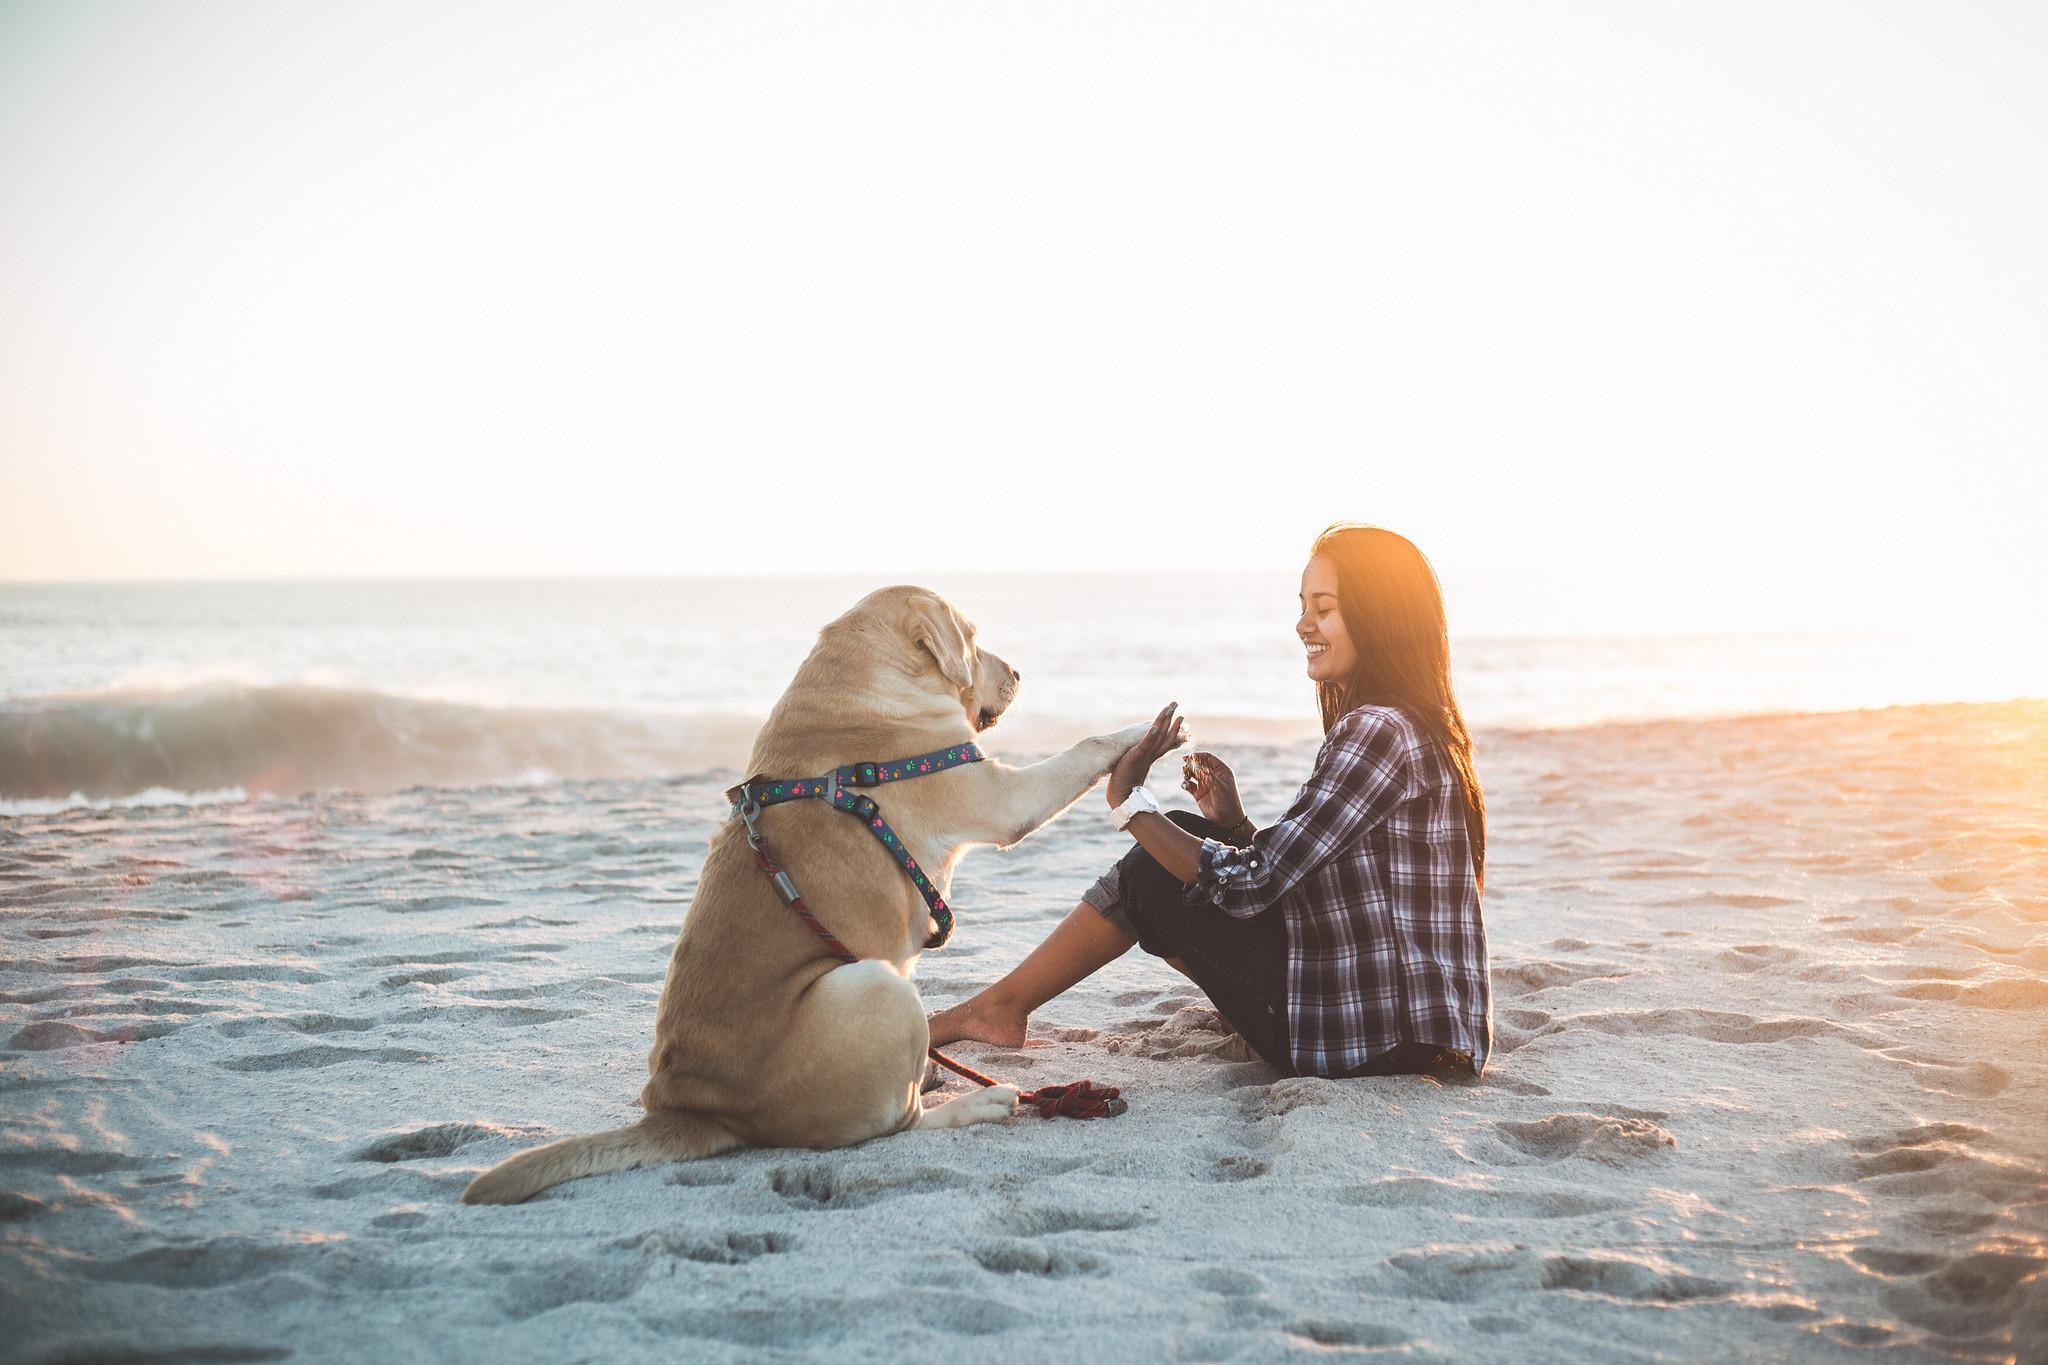

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Describe this image.
Answer:
The image depicts a serene beach scene with a woman and a dog. The woman is sitting on the sand, smiling and making a high-five gesture with her hand. She is wearing a plaid shirt and black pants. The dog, which appears to be a Labrador Retriever, is sitting on the sand next to her, with its front paws raised in a high-five position. The dog is wearing a colorful harness. The background shows the ocean with gentle waves, and the sky is clear


In [9]:
from PIL import Image
from transformers import AutoProcessor, AutoTokenizer
from qwen_vl_utils import process_vision_info
from transformers import TextStreamer


min_pixels = 256 * 28 * 28
max_pixels = 1280 * 28 * 28
processor = AutoProcessor.from_pretrained(model_dir, min_pixels=min_pixels, max_pixels=max_pixels)

if processor.chat_template is None:
    tok = AutoTokenizer.from_pretrained(model_dir)
    processor.chat_template = tok.chat_template

example_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
example_image_path = Path("demo.jpeg")

if not example_image_path.exists():
    Image.open(requests.get(example_image_url, stream=True).raw).save(example_image_path)

image = Image.open(example_image_path)
question = "Describe this image."

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"file://{example_image_path}",
            },
            {"type": "text", "text": question},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

display(image)
print("Question:")
print(question)
print("Answer:")

generated_ids = model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

In [10]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2-vl/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

In [11]:
from gradio_helper import make_demo


demo = make_demo(model, processor)

try:
    demo.launch(debug=False)
except Exception:
    demo.launch(debug=False, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 你好👋
Qwen-VL-Chat: 你好！


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 你是谁
Qwen-VL-Chat: 我是来自阿里云的大规模语言模型，我叫通义千问。


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 你能做什么
Qwen-VL-Chat: 我能够回答各种问题，包括但不限于天气预报、新闻资讯、历史事件、科学知识、文学作品、文化历史、烹饪美食、娱乐新闻、体育赛事、法律知识、科技资讯、健康医疗、宠物护理、旅行攻略、美食推荐、时尚潮流、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、宠物护理、


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 请描述一下这张图片
Qwen-VL-Chat: 我需要一张图片才能描述它。


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 请描述一下这张图片
Qwen-VL-Chat: 这张图片展示了两个不同的场景。<br>1. **女性站在城市街道上**：<br>   - 女性穿着黑色的无袖上衣和黑色的短裤，站在一条街道上。<br>   - 她的头发是深色的，披散在肩上。<br>   - 她的姿势是站立，双手交叉在胸前，目光看向镜头。<br>2. **女性站在海边**：<br>   - 女性穿着白色的长裙，站在海边。<br>   - 海边有岩石和海浪，远处是山脉和天空。<br>   - 女性背对着镜头，面向大海。<br>这两个场景可能代表不同的生活状态或情感状态。


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: 描述一下这张图片
Qwen-VL-Chat: 这张图片展示了两个不同的场景。第一个场景是一个女性站在城市街道上，她穿着黑色的无袖上衣和黑色的短裤，双手交叉在胸前，目光看向镜头。第二个场景是一个女性站在海边，她穿着白色的长裙，背对着镜头，面向大海。远处是山脉和天空。
